In [2]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# read in all the words
words = open('./datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [14]:
# Intial loss should be what we expect
# Loss curve should not look like hockey stick
# Start with Normally distributed logits near to zero 
# This will have less loss
# This means actually spending the time on optimizing the neural network
# Not on squashing down the weight
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

(array([473., 236., 208., 155., 141., 128., 108., 102.,  99., 108.,  78.,
         93., 106.,  85.,  86., 112., 119., 120., 109., 103., 112., 103.,
        112.,  86., 100., 125.,  97.,  78., 118.,  91.,  84., 109., 107.,
         88., 105.,  86.,  81.,  78., 107.,  88., 103., 106.,  80., 128.,
        141., 114., 137., 184., 232., 451.]),
 array([-9.99970257e-01, -9.59970877e-01, -9.19971497e-01, -8.79972117e-01,
        -8.39972737e-01, -7.99973357e-01, -7.59973977e-01, -7.19974597e-01,
        -6.79975216e-01, -6.39975836e-01, -5.99976456e-01, -5.59977076e-01,
        -5.19977696e-01, -4.79978316e-01, -4.39978936e-01, -3.99979556e-01,
        -3.59980175e-01, -3.19980795e-01, -2.79981415e-01, -2.39982035e-01,
        -1.99982655e-01, -1.59983275e-01, -1.19983895e-01, -7.99845147e-02,
        -3.99851346e-02,  1.42455101e-05,  4.00136256e-02,  8.00130057e-02,
         1.20012386e-01,  1.60011766e-01,  2.00011146e-01,  2.40010526e-01,
         2.80009906e-01,  3.20009286e-01,  3.60008

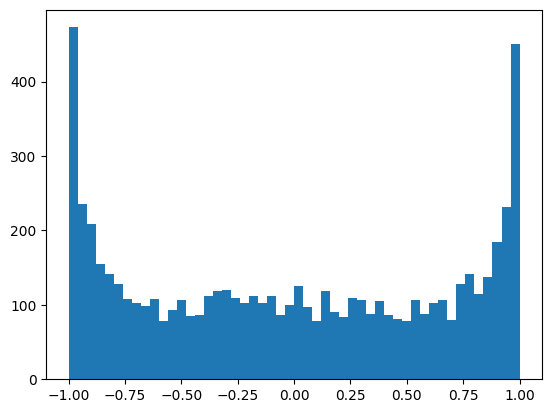

In [ ]:
# since I copied the code it is well distributed :(
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   2.,   2.,   1.,   7.,  13.,  17.,  27.,  32.,  56.,
         72.,  98., 115., 150., 209., 244., 301., 350., 407., 613., 660.,
        603., 499., 396., 340., 253., 217., 176., 140., 126.,  86.,  67.,
         39.,  24.,  21.,   9.,   6.,   6.,   2.,   5.,   1.,   1.,   1.,
          0.,   2.,   0.,   1.,   0.,   1.]),
 array([-5.55808973, -5.30401786, -5.04994598, -4.79587411, -4.54180223,
        -4.28773036, -4.03365849, -3.77958661, -3.52551474, -3.27144286,
        -3.01737099, -2.76329911, -2.50922724, -2.25515536, -2.00108349,
        -1.74701161, -1.49293974, -1.23886786, -0.98479599, -0.73072412,
        -0.47665224, -0.22258037,  0.03149151,  0.28556338,  0.53963526,
         0.79370713,  1.04777901,  1.30185088,  1.55592276,  1.80999463,
         2.06406651,  2.31813838,  2.57221025,  2.82628213,  3.080354  ,
         3.33442588,  3.58849775,  3.84256963,  4.0966415 ,  4.35071338,
         4.60478525,  4.85885713,  5.112929  ,  5.36700088,  5.62107275,
 

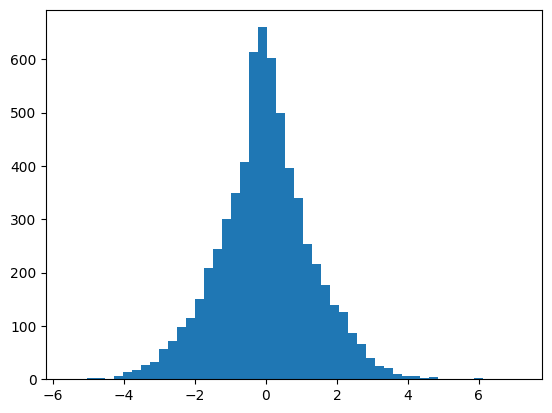

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50)

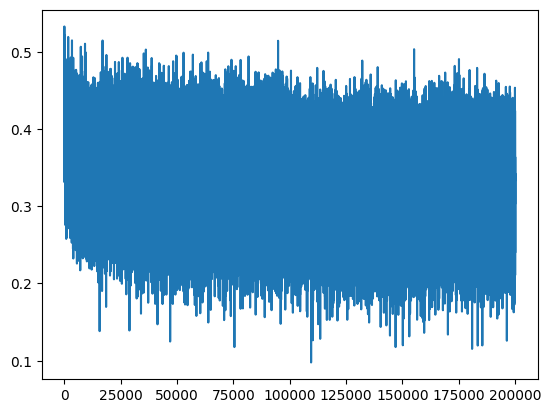

In [ ]:
plt.plot(lossi)

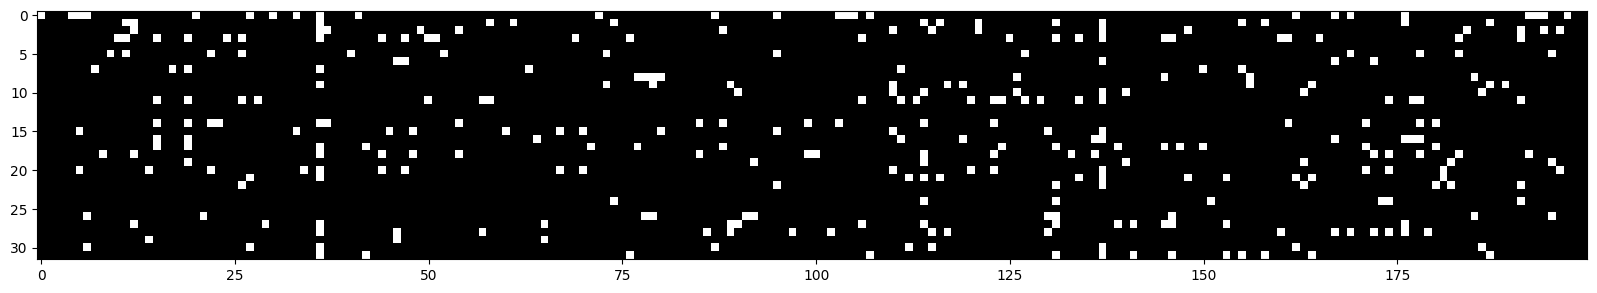

In [20]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

(array([2.00828876e-05, 2.00828876e-05, 0.00000000e+00, 2.00828876e-05,
        4.01657751e-05, 6.02486627e-05, 6.02486627e-05, 1.80745988e-04,
        5.82403740e-04, 6.82818177e-04, 8.03315503e-04, 1.96812298e-03,
        3.17309624e-03, 4.55881548e-03, 8.07332080e-03, 1.34555347e-02,
        2.21313421e-02, 3.52655506e-02, 5.49467804e-02, 8.21390102e-02,
        1.22023625e-01, 1.73094408e-01, 2.38464207e-01, 3.10180199e-01,
        3.73742538e-01, 4.13687401e-01, 4.28669235e-01, 4.03384880e-01,
        3.52796086e-01, 2.87787779e-01, 2.17096015e-01, 1.56244865e-01,
        1.09190660e-01, 7.48489220e-02, 4.71747029e-02, 3.05661549e-02,
        1.96209812e-02, 1.14472459e-02, 7.00892776e-03, 4.73956147e-03,
        2.69110693e-03, 1.56646523e-03, 1.14472459e-03, 5.82403740e-04,
        3.41409089e-04, 1.80745988e-04, 2.00828876e-05, 6.02486627e-05,
        2.00828876e-05, 2.00828876e-05]),
 array([-6.5594759 , -6.31050772, -6.06153954, -5.81257135, -5.56360317,
        -5.31463499, 

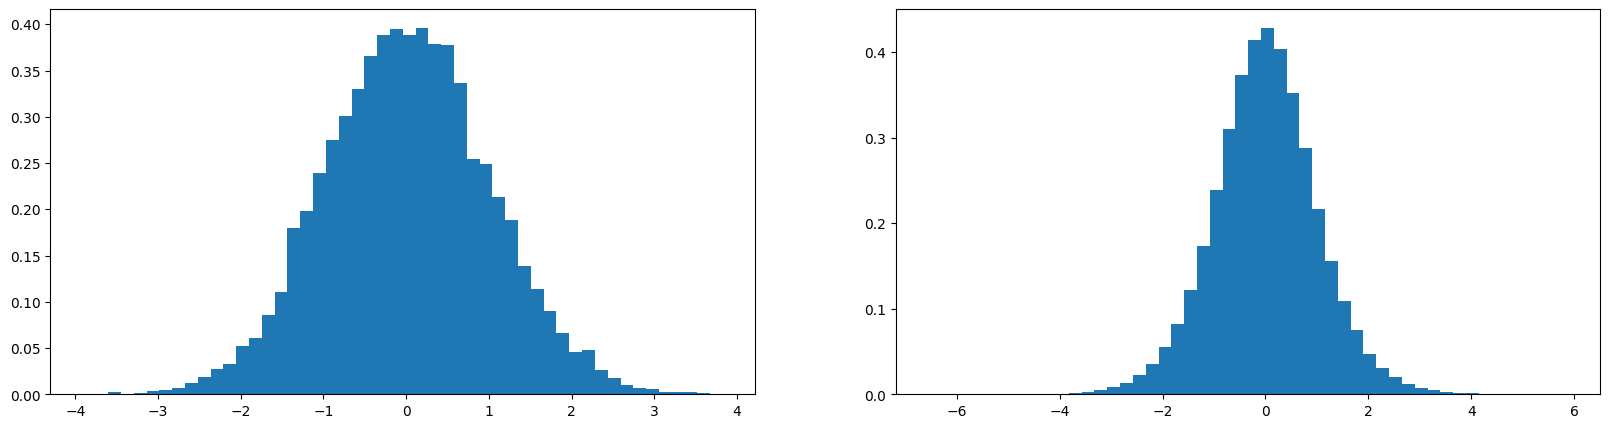

In [26]:
x = torch.randn(1000, 10)
x.shape
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w # Dot product
# print(x.mean(), x.std())
# print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [ ]:
# Real fun starts here
print("fun")

fun


In [1]:
# Lot to learn in this notebook
# Relu, Sigmoid Tanh, Softmax
# Need to understand gaussian and standard deviation
# What is the diff between gaussian distribution and uniform distribution and Normal distribution
# Variance and Standard Deviation

# Batch Normalization
# Using batch Normalization to control the statistics of activation function in neural network
# Non linearity helps neural network to approximate any arbitrary function/expression
# Batch Nomalization, pytorch, Diagnostic tools to understand what is going on with network and training
# Get the intitution is the main thing in Engineering, programming and research

In [ ]:
# Practice

In [ ]:
# Create class and layers and MLP 
# to train neural networks
# with using batch normalization
class Linear: